In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from xgboost import XGBClassifier
from collections import Counter

import os
import glob
import mglearn
import sklearn
import sklearn.datasets
from numpy import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from string import ascii_letters
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
shap.initjs()

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [3]:
def read_files(name):
    path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem' # use your path
    all_files = glob.glob(os.path.join(path, '*'+name+'.csv'))
    print('*'+name+'.csv')
    frame = pd.DataFrame()
    df = pd.concat((pd.read_csv(f) for f in all_files)).reset_index(drop=True)
    return df

In [4]:
df_train_all = read_files('train')
df_test_all = read_files('test')
df_valid_all = read_files('valid-this')

*train.csv
*test.csv
*valid-this.csv


In [6]:
df_train_all.head()

,IDVAR_GMT_MUTATIE,IDVAR_META_HASH,label,fraud_class,C_000,C_001,C_002,C_003,C_004,C_005,...,V_007,V_008,V_009,V_010,V_011,V_012,V_013,V_014,V_015,V_016
0,2017-07-01 01:16:10,Ltp2YyhB5Oo7Ywm+L2AGaVhJxQw=,1,Mo2,0.1,0.106,0.100,0.124,0.1,0.1,...,0.123,0.100,0.102,0.105,0.102,0.136,0.105,0.111,0.05,0.100
1,2017-07-01 02:00:58,PeCPA86RzbqZR18/tLUvikgwUNc=,1,Mo2,0.1,0.106,0.100,0.100,0.1,0.1,...,0.123,0.100,0.102,0.105,0.102,0.142,0.105,0.111,0.05,0.100
2,2017-07-01 08:43:27,+WGwqT5E/+zJ6MZ9yy50pG0awb0=,1,Mo1,0.1,0.106,0.100,0.212,0.1,0.1,...,0.050,0.103,0.102,0.105,0.102,0.100,0.104,0.100,0.05,0.118
3,2017-07-01 08:48:11,l6glV/qzuPhE34SBB2LFE5YP1v8=,1,Mo1,0.1,0.120,0.124,0.212,0.1,0.1,...,0.050,0.103,0.102,0.105,0.102,0.176,0.118,0.108,0.05,0.100
4,2017-07-01 19:11:20,IR6NOzGwaD4WuJgcdphrzc+5oGA=,1,Mo1,0.1,0.116,0.100,0.102,0.1,0.1,...,0.050,0.103,0.102,0.105,0.102,0.131,0.118,0.101,0.05,0.100


In [7]:
df_train_all['fraud_label'] = np.where((df_train_all['fraud_class'] == 'Mo2'), 1, 0)
df_test_all['fraud_label'] = np.where((df_test_all['fraud_class'] == 'Mo2'), 1, 0)
df_valid_all['fraud_label'] = np.where((df_valid_all['fraud_class'] == 'Mo2'), 1, 0)

In [8]:
df_train_all.head()

,IDVAR_GMT_MUTATIE,IDVAR_META_HASH,label,fraud_class,C_000,C_001,C_002,C_003,C_004,C_005,...,V_008,V_009,V_010,V_011,V_012,V_013,V_014,V_015,V_016,fraud_label
0,2017-07-01 01:16:10,Ltp2YyhB5Oo7Ywm+L2AGaVhJxQw=,1,Mo2,0.1,0.106,0.100,0.124,0.1,0.1,...,0.100,0.102,0.105,0.102,0.136,0.105,0.111,0.05,0.100,1
1,2017-07-01 02:00:58,PeCPA86RzbqZR18/tLUvikgwUNc=,1,Mo2,0.1,0.106,0.100,0.100,0.1,0.1,...,0.100,0.102,0.105,0.102,0.142,0.105,0.111,0.05,0.100,1
2,2017-07-01 08:43:27,+WGwqT5E/+zJ6MZ9yy50pG0awb0=,1,Mo1,0.1,0.106,0.100,0.212,0.1,0.1,...,0.103,0.102,0.105,0.102,0.100,0.104,0.100,0.05,0.118,0
3,2017-07-01 08:48:11,l6glV/qzuPhE34SBB2LFE5YP1v8=,1,Mo1,0.1,0.120,0.124,0.212,0.1,0.1,...,0.103,0.102,0.105,0.102,0.176,0.118,0.108,0.05,0.100,0
4,2017-07-01 19:11:20,IR6NOzGwaD4WuJgcdphrzc+5oGA=,1,Mo1,0.1,0.116,0.100,0.102,0.1,0.1,...,0.103,0.102,0.105,0.102,0.131,0.118,0.101,0.05,0.100,0


In [9]:
df_train_all["fraud_label"].value_counts()

0    598942
1      1149
Name: fraud_label, dtype: int64

In [10]:
df_test_all["fraud_label"].value_counts()

0    598031
1       379
Name: fraud_label, dtype: int64

In [11]:
df_valid_all["fraud_label"].value_counts()

0    598094
1       384
Name: fraud_label, dtype: int64

In [12]:
X_train = df_train_all.iloc[:,4:-1]
y_train = df_train_all['fraud_label']
X_test = df_test_all.iloc[:,4:-1]
y_test = df_test_all['fraud_label']
X_valid = df_valid_all.iloc[:,4:-1]
y_valid = df_valid_all['fraud_label']

In [13]:
def undersampling(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
#    ratio={0: second_class}
    ratio={0: int(major_class/r)}
    print(C)
    with Timer('Under-sampling using '+ sampler.__class__.__name__):
        uds = sampler
        uds.set_params(ratio=ratio, random_state=0)
        X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [14]:
X_traintest = pd.concat((X_train, X_test)).reset_index(drop=True)
y_traintest = pd.concat((pd.DataFrame(y_train), pd.DataFrame(y_test))).reset_index(drop=True)

In [15]:
Counter(y_traintest.values.flatten())

Counter({0: 1196973, 1: 1528})

In [16]:
X_traintest_sampled, y_traintest_sampled = undersampling(X_traintest, y_traintest.values.flatten(), 
                                                         RandomUnderSampler(random_state=0), 30)

Counter({0: 1196973, 1: 1528})
[Under-sampling using RandomUnderSampler]
Elapsed: 69.50082802772522
X_resampled.shape: (41427, 585), y_resampled: (41427,)
y_resample:
0    39899
1     1528
dtype: int64


In [17]:
def evaluate_scores(X_valid, y_valid, clf):
    print("AUC score: {:.3f}".format(roc_auc_score(y_valid, clf.predict(X_valid))))
    print("Accuracy score: {:.3f}".format(accuracy_score(y_valid, clf.predict(X_valid))))
    print("F1-micro score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="micro")))
#     print("F1-weighted score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="weighted")))
    print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(y_valid, clf.predict(X_valid))))
    print(classification_report(y_valid, clf.predict(X_valid)))

In [17]:
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_traintest_sampled, np.array(y_traintest_sampled).ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
evaluate_scores(X_valid, y_valid, clf)

AUC score: 0.973
Accuracy score: 1.000
F1-micro score: 1.000
Cohen kappa score: 0.877
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    598094
          1       0.82      0.95      0.88       384

avg / total       1.00      1.00      1.00    598478



In [18]:
X_traintest_sampled = pd.DataFrame(X_traintest_sampled, columns=list(X_traintest))

### Feature selection with Random Forests

In [20]:
thresholds = range(15, 39, 3)

In [27]:
n = []
cv_accuracy = []
for thresh in thresholds:
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]

    # training model
    selection_model = RandomForestClassifier(n_estimators=500, random_state=0)
    # perform cross-validation
    scores = cross_val_score(selection_model, X_traintest_selected, y_traintest_sampled, cv=5)
     # compute mean cross-validation accuracy
    accuracy = np.mean(scores)    
    cv_accuracy.append(accuracy)
    n.append(X_traintest_selected.shape[1])
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, X_traintest_selected.shape[1], accuracy*100.0))

Thresh=15.000, n=35, Accuracy: 99.43%
Thresh=18.000, n=32, Accuracy: 99.43%
Thresh=21.000, n=25, Accuracy: 99.42%
Thresh=24.000, n=22, Accuracy: 99.37%
Thresh=27.000, n=21, Accuracy: 99.32%
Thresh=30.000, n=21, Accuracy: 99.32%
Thresh=33.000, n=18, Accuracy: 99.30%
Thresh=36.000, n=15, Accuracy: 99.30%


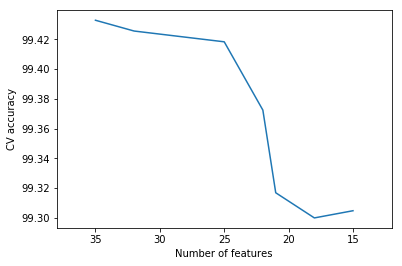

In [29]:
plt.plot(n, np.asarray(cv_accuracy)*100.0, label="cv accuracy")
plt.xlim(38, 12)
plt.xlabel("Number of features")
plt.ylabel("CV accuracy")

In [19]:
def feature_selection(thresh, X_traintest_sampled, y_traintest_sampled, X_valid):
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]
    return X_traintest_selected, X_valid_selected

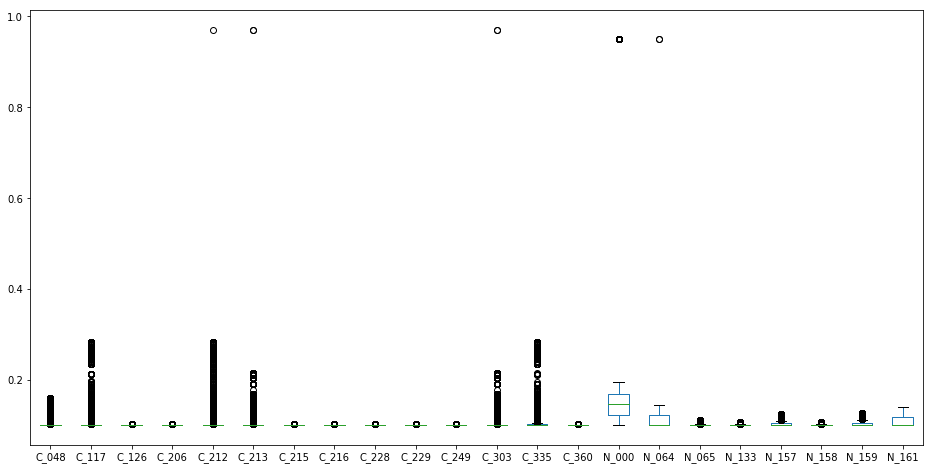

In [20]:
X_traintest_selected, X_valid_selected = feature_selection(24, X_traintest_sampled, y_traintest_sampled, X_valid)
X_traintest_selected.plot.box(figsize=(16,8))

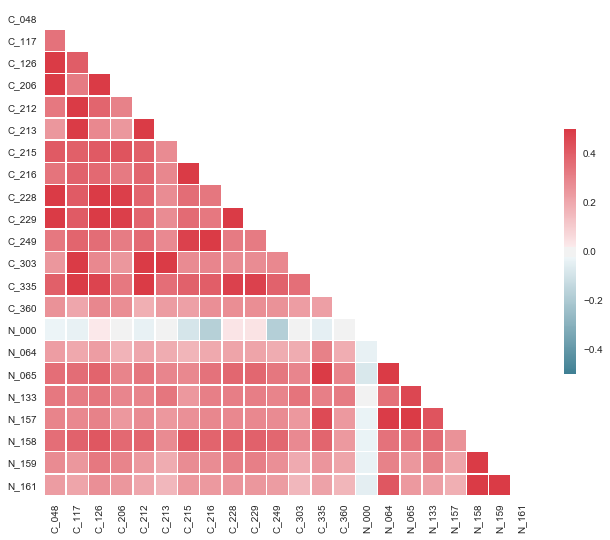

In [21]:
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=X_traintest_selected,
                 columns=list(X_traintest_selected))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
corr.abs().sum().mean()

7.7793296316551155

In [23]:
xgb_traintest = xgboost.DMatrix(X_traintest_selected, label=y_traintest_sampled)
xgb_valid = xgboost.DMatrix(X_valid_selected, label=y_valid)

In [25]:
gridsearch_params = [
    (max_depth, min_child_weight, n_estimators, subsample, colsample)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
    for n_estimators in [100, 200, 500, 1000]
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [26]:
params = {'max_depth':20, 'n_estimators':500,
         'objective': 'multi:softmax', 'num_class': 2
}

In [27]:
# Define initial best params and MAE
num_boost_round = 999
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight, n_estimators, subsample, colsample in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, n_estimators={}, subsample={}, colsample={}".format(
                             max_depth,
                             min_child_weight,
                             n_estimators,
                             subsample,
                             colsample))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['n_estimators'] = n_estimators
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

# for subsample, colsample in reversed(gridsearch_params):
#     print("CV with subsample={}, colsample={}".format(
#                              subsample,
#                              colsample))

#     # Update the parameters
#     params['subsample'] = subsample
#     params['colsample_bytree'] = colsample
    
#     params['objective'] = 'multi:softmax'
#     params['num_class'] = 5
    
    # Run CV
    cv_results = xgboost.cv(
        params,
        xgb_traintest,
        num_boost_round=num_boost_round,
        seed=0,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=10
    )

    # Update best Merror
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].idxmin()
    print("\tMerror {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth, min_child_weight, n_estimators, subsample, colsample)
print("Best params: {}, {}, {}, {}, {}, Merror: {}".format(best_params[0], best_params[1], best_params[2], 
        best_params[3], best_params[4], min_merror))

#         best_params = (subsample, colsample)
# print("Best params: {}, {}, Merror: {}".format(best_params[0], best_params[1], min_merror))

CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=0.7
	Merror 0.0054554 for 50 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=0.8
	Merror 0.005744999999999999 for 15 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=0.9
	Merror 0.0053104 for 49 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.7, colsample=1.0
	Merror 0.0055038000000000005 for 48 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=0.7
	Merror 0.0056968 for 45 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=0.8
	Merror 0.0055278 for 43 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=0.9
	Merror 0.005552 for 40 rounds
CV with max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8, colsample=1.0
	Merror 0.0056002000000000005 for 48 rounds
CV wit

	Merror 0.0058658 for 18 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.7, colsample=1.0
	Merror 0.0056004 for 56 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=0.7
	Merror 0.0059382 for 13 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=0.8
	Merror 0.0054794 for 47 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=0.9
	Merror 0.0056484 for 53 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.8, colsample=1.0
	Merror 0.005576200000000001 for 28 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.7
	Merror 0.005552 for 48 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.0056002 for 46 rounds
CV with max_depth=9, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.9
	Merror 0.0059142 for 23 round

	Merror 0.005841799999999999 for 25 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.8, colsample=1.0
	Merror 0.0057209999999999995 for 49 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=0.7
	Merror 0.0060106 for 15 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.0053586 for 54 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=0.9
	Merror 0.0059624 for 13 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=0.9, colsample=1.0
	Merror 0.0060831999999999995 for 16 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.0056966000000000004 for 33 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.0057932 for 28 rounds
CV with max_depth=9, min_child_weight=7, n_estimators=100, subsample=1.0, colsamp

	Merror 0.0055762 for 54 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=0.7
	Merror 0.0054798 for 39 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.0058658 for 26 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=0.9
	Merror 0.005817600000000001 for 25 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.9, colsample=1.0
	Merror 0.0056968 for 35 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.0055518 for 33 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.0056002000000000005 for 37 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=0.9
	Merror 0.0057209999999999995 for 44 rounds
CV with max_depth=10, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=1

	Merror 0.0056244 for 37 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.8
	Merror 0.005527799999999999 for 47 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=0.9
	Merror 0.0056966 for 38 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=0.9, colsample=1.0
	Merror 0.0057209999999999995 for 32 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.005479400000000001 for 29 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.005552 for 26 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=0.9
	Merror 0.0056484 for 28 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=100, subsample=1.0, colsample=1.0
	Merror 0.0057936 for 32 rounds
CV with max_depth=10, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=0.7

	Merror 0.0055758 for 57 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.7
	Merror 0.0060106 for 11 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.8
	Merror 0.0056726 for 43 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=0.9
	Merror 0.005576 for 43 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=100, subsample=1.0, colsample=1.0
	Merror 0.0058656 for 34 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=0.7
	Merror 0.0057934 for 25 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=0.8
	Merror 0.0059864 for 14 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=0.9
	Merror 0.0058416 for 17 rounds
CV with max_depth=10, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.0056726 for 38 rounds
C

	Merror 0.0056004 for 61 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=100, subsample=1.0, colsample=1.0
	Merror 0.005527599999999999 for 50 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.7
	Merror 0.0060831999999999995 for 13 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.8
	Merror 0.005383000000000001 for 36 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=0.9
	Merror 0.005479400000000001 for 56 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.0056002 for 40 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.0055036 for 53 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, colsample=0.8
	Merror 0.0056484 for 36 rounds
CV with max_depth=11, min_child_weight=5, n_estimators=200, subsample=0.8, c

	Merror 0.0056726 for 37 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=0.8
	Merror 0.0059866 for 13 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=0.9
	Merror 0.0060106 for 12 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.0056726 for 29 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.0055038 for 43 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=0.8
	Merror 0.0056484 for 39 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=0.9
	Merror 0.005528 for 33 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.8, colsample=1.0
	Merror 0.0059624 for 13 rounds
CV with max_depth=11, min_child_weight=6, n_estimators=200, subsample=0.9, colsample=0.7
	Merror 0.005769399999999999 for 

	Merror 0.0057936 for 30 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.7, colsample=1.0
	Merror 0.006083 for 14 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.7
	Merror 0.0054312 for 61 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.8
	Merror 0.0059382 for 13 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=0.9
	Merror 0.0053106 for 49 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.8, colsample=1.0
	Merror 0.0061072 for 10 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=0.7
	Merror 0.0058656 for 26 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=0.8
	Merror 0.005697 for 42 rounds
CV with max_depth=11, min_child_weight=7, n_estimators=200, subsample=0.9, colsample=0.9
	Merror 0.0057932 for 36 rounds
CV

In [28]:
best_params

(9, 5, 100, 0.7, 0.9)

In [24]:
# use validation set to choose # of trees
params = {'max_depth':20, 'n_estimators':500,
          'objective': 'multi:softmax', 'num_class': 2
#           'objective': 'binary:logistic'
}

params['max_depth'] = 9
params['min_child_weight'] = 5
params['n_estimators'] = 100
params['subsample'] = .7
params['colsample_bytree'] = .9

In [25]:
xgb = xgboost.train(params, xgb_traintest, 100)

In [26]:
params

{'colsample_bytree': 0.9,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 100,
 'num_class': 2,
 'objective': 'multi:softmax',
 'subsample': 0.7}

In [27]:
# ypred_bst = np.array(xgb.predict(xgb_valid))
# ypred_bst = ypred_bst > 0.5  
# ypred_bst = ypred_bst.astype(int)

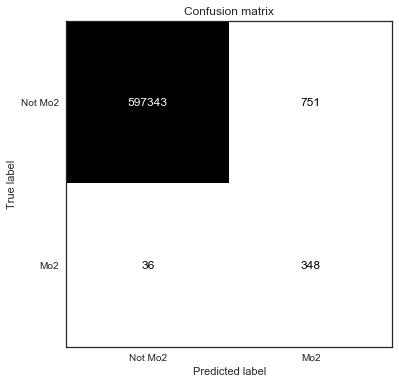

In [29]:
f, ax = plt.subplots(figsize=(6, 6))
target_names = ['Not Mo2', 'Mo2']
scores_image = mglearn.tools.heatmap(
     confusion_matrix(y_valid, xgb.predict(xgb_valid)), xlabel='Predicted label',
#     confusion_matrix(y_valid, ypred_bst), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [30]:
evaluate_scores(xgb_valid, y_valid, xgb)

AUC score: 0.952
Accuracy score: 0.999
F1-micro score: 0.999
Cohen kappa score: 0.469
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    598094
          1       0.32      0.91      0.47       384

avg / total       1.00      1.00      1.00    598478



In [27]:
Mo2_tp = y_valid.index[(y_valid==1) & (xgb.predict(xgb_valid)==1)].tolist()
Mo2_fp = y_valid.index[(y_valid==0) & (xgb.predict(xgb_valid)==1)].tolist()
Mo2_tn = y_valid.index[(y_valid==0) & (xgb.predict(xgb_valid)==0)].tolist()
Mo2_fn = y_valid.index[(y_valid==1) & (xgb.predict(xgb_valid)==0)].tolist()

In [ ]:
Mo2_fp_samples = random.choice(Mo2_fp, len(Mo2_tp))
Mo2_tn_samples = random.choice(Mo2_tn, len(Mo2_fn))

In [28]:
xgb_valid_Mo2_tp = xgboost.DMatrix(X_valid_selected.iloc[Mo2_tp,:], label=y_valid.loc[Mo2_tp])
xgb_valid_Mo2_fp = xgboost.DMatrix(X_valid_selected.iloc[Mo2_fp_samples,:], label=y_valid.loc[Mo2_fp_samples])
xgb_valid_Mo2_tn = xgboost.DMatrix(X_valid_selected.iloc[Mo2_tn_samples,:], label=y_valid.loc[Mo2_tn_samples])
xgb_valid_Mo2_fn = xgboost.DMatrix(X_valid_selected.iloc[Mo2_fn,:], label=y_valid.loc[Mo2_fn])

In [29]:
shap_values_xgb_Mo2_tp = xgb.predict(xgb_valid_Mo2_tp, pred_contribs=True)
shap_values_xgb_Mo2_fp = xgb.predict(xgb_valid_Mo2_fp, pred_contribs=True)
shap_values_xgb_Mo2_tn = xgb.predict(xgb_valid_Mo2_tn, pred_contribs=True)
shap_values_xgb_Mo2_fn = xgb.predict(xgb_valid_Mo2_fn, pred_contribs=True)

In [33]:
shap_interaction_values_Mo2 = xgb.predict(xgb_valid_Mo2, pred_interactions=True)

In [32]:
np.var(shap_values_xgb_Mo2_tp[:, 1, :], axis=1).mean()

0.38860092

In [33]:
np.var(shap_values_xgb_Mo2_fp[:, 1, :], axis=1).mean()

0.38238367

In [62]:
shap.force_plot(shap_values_xgb_Mo2_tp[:, 1, :], X_valid_selected.iloc[Mo2_tp,:])

In [78]:
shap.force_plot(shap_values_xgb_Mo2_fp[:, 1, :], X_valid_selected.iloc[Mo2_fp,:])

In [31]:
shap.force_plot(shap_values_xgb_Mo2_fn[:, 1, :], X_valid_selected.iloc[Mo2_fn,:])

In [30]:
shap.force_plot(shap_values_xgb_Mo2_tn[:, 1, :], X_valid_selected.iloc[Mo2_tn,:])

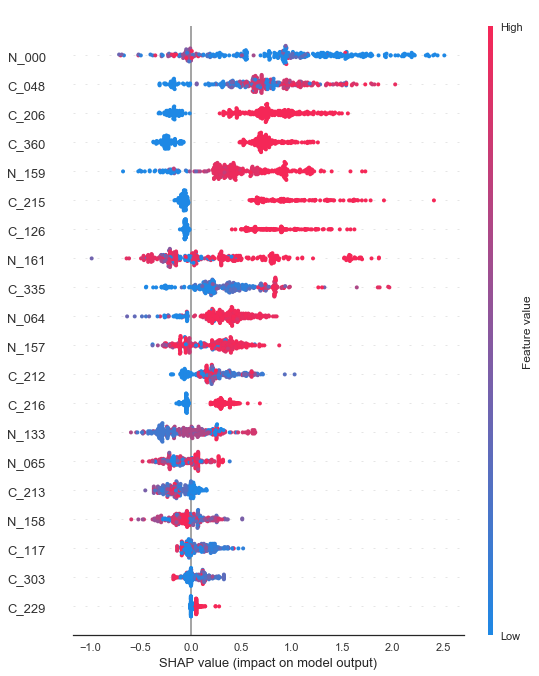

In [79]:
shap.summary_plot(shap_values_xgb_Mo2_tp[:, 1, :], X_valid_selected.iloc[Mo2_tp,:])

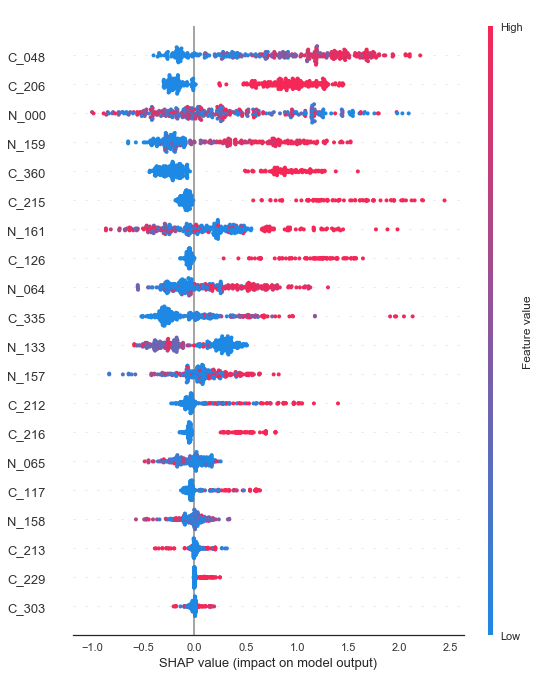

In [81]:
shap.summary_plot(shap_values_xgb_Mo2_fp[:, 1, :], X_valid_selected.iloc[Mo2_fp_samples,:])

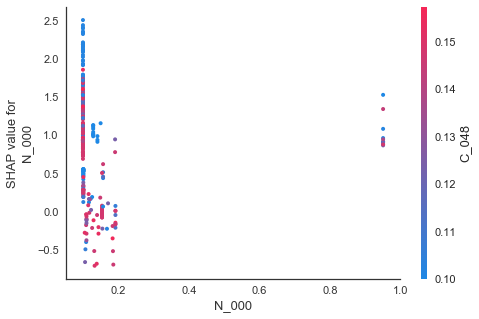

In [56]:
shap.dependence_plot("N_000", shap_values_xgb_Mo2[:, 1, :], X_valid_selected.iloc[Mo2,:])#,
#                      interaction_index="N_000")

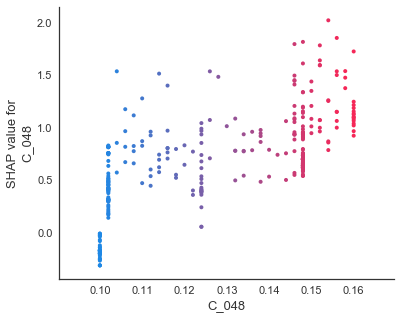

In [40]:
shap.dependence_plot("C_048", shap_values_xgb_Mo2[:, 1, :], X_valid_selected.iloc[Mo2,:],
                     interaction_index="C_048")

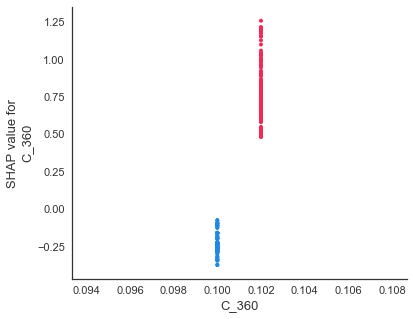

In [42]:
shap.dependence_plot("C_360", shap_values_xgb_Mo2[:, 1, :], X_valid_selected.iloc[Mo2,:],
                     interaction_index="C_360")

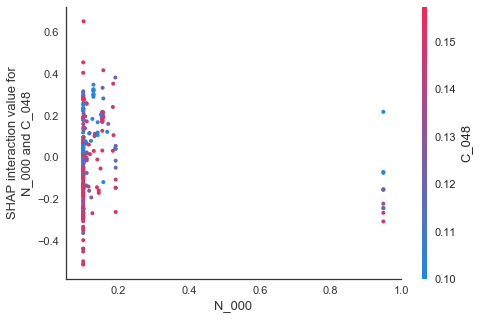

In [57]:
shap.dependence_plot(
    ("N_000", "C_048"),
    shap_interaction_values_Mo2[:, 1, :], X_valid_selected.iloc[Mo2,:]#,
#     display_features=X_display.iloc[:2000,:]
)

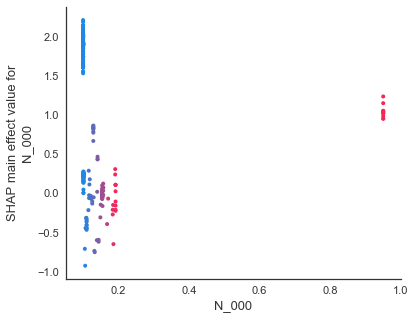

In [58]:
shap.dependence_plot(
    ("N_000", "N_000"),
    shap_interaction_values_Mo2[:, 1, :], X_valid_selected.iloc[Mo2,:]#,
#     display_features=X_display.iloc[:2000,:]
)

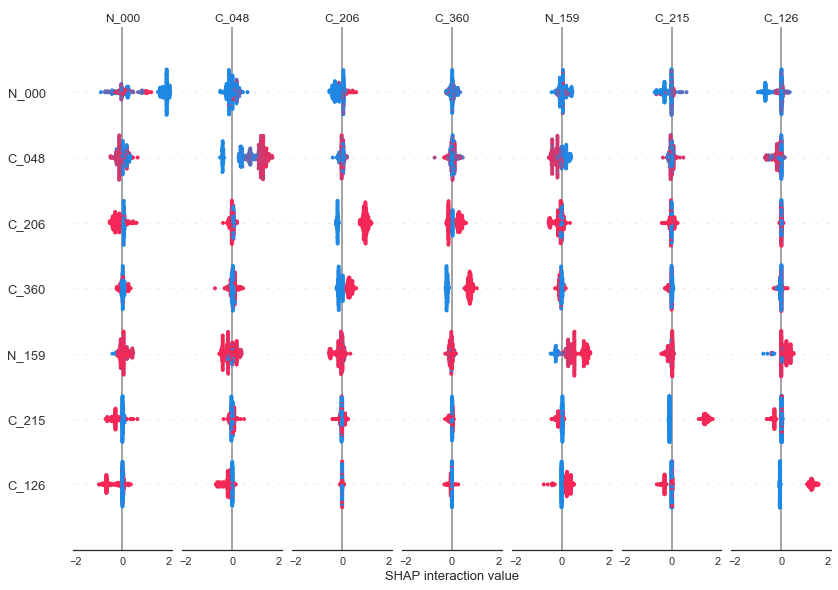

In [47]:
shap.summary_plot(shap_interaction_values_Mo2[:, 1, :], X_valid_selected.iloc[Mo2,:])